Import tools

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Data

In [2]:
col_names = ["sepal_length","sepal_width","petal_length","petal_width","type"]
iris_data = pd.read_csv("Iris.csv", skiprows=1, header=None, names=col_names)
display(iris_data)

,sepal_length,sepal_width,petal_length,petal_width,type
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,Iris-virginica
147,6.3,2.5,5.0,1.9,Iris-virginica
148,6.5,3.0,5.2,2.0,Iris-virginica
149,6.2,3.4,5.4,2.3,Iris-virginica


Visualizing Data

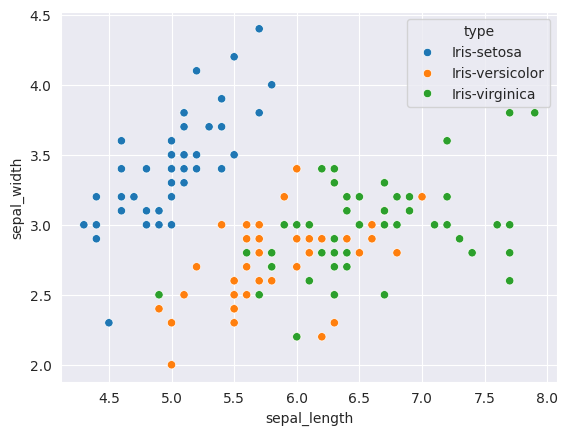

In [3]:
sns.scatterplot(x='sepal_length', y='sepal_width', hue='type', data=iris_data)
plt.show()

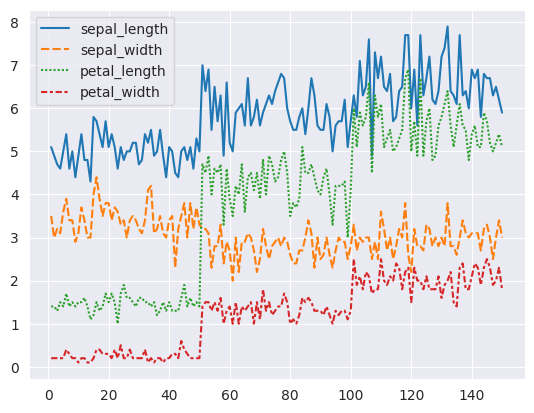

In [4]:
sns.lineplot(data=iris_data.drop(['type'], axis=1))
plt.show()

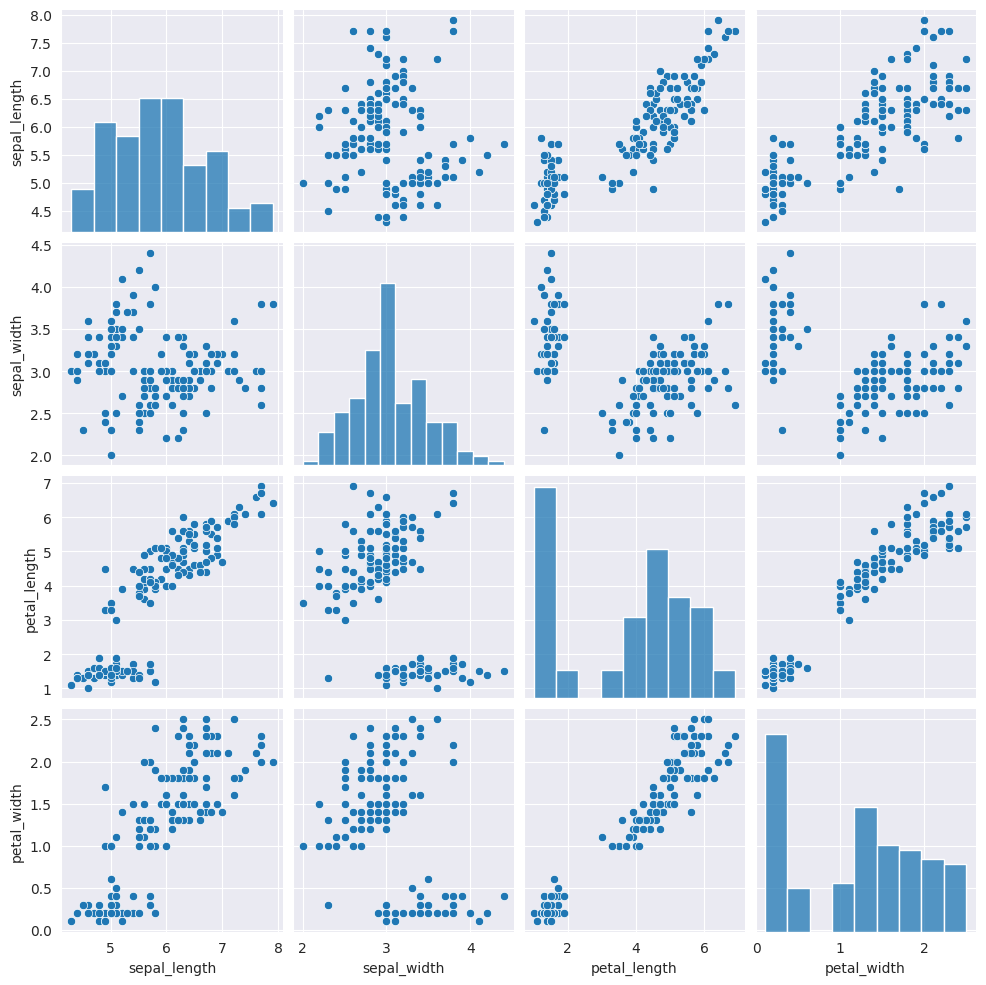

In [5]:
sns.pairplot(iris_data)

Node Class

In [6]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        #for decision nodes
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        #for leaf nodes
        self.value = value

Classification Tree class

In [7]:
class DecisionTreeClasifier:
    def __init__(self, min_samples_split = 2, max_depth = 2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
    def buildtree(self, dataset, curr_depth = 0):
        
        X,Y = dataset[:,:-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)
        
        if num_samples>=self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.buildtree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.buildtree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        leaf_value = self.calculate_leaf_value(Y)  # calculates the most occuring class
        
        return Node(value = leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        #storing best split in a dictionary
        best_split = {}
        max_info_gain = -float("inf")
        #looping over features
        for feature_index in range(num_features):
            feature_values = dataset[:,feature_index]
            possible_thresholds = np.unique(feature_values)
            #looping over all feature values
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                if len(dataset_right)==0 or len(dataset_left)==0:
                    continue
                y, y_left, y_right = dataset[:,-1], dataset_left[:,-1], dataset_right[:,-1]
                curr_info_gain = self.information_gain(y,y_left,y_right)
                
                if curr_info_gain > max_info_gain:
                    best_split["feature_index"] = feature_index
                    best_split["threshold"] = threshold
                    best_split["info_gain"] = curr_info_gain
                    best_split["dataset_left"] = dataset_left
                    best_split["dataset_right"] = dataset_right
                    max_info_gain = curr_info_gain
        
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left,dataset_right
    
    def information_gain(self, parent, left_child, right_child):
        
        weight_l = len(left_child)/len(parent)
        weight_r = len(right_child)/len(parent)
        
        gain = self.gini_index(parent) - (weight_l * self.gini_index(left_child) + weight_r * self.gini_index(right_child))
        
        return gain
    
    def gini_index(self, y):
        
        class_labels = np.unique(y)
        gini = 0
        
        for cls in class_labels:
            p_cls = len(y[y==cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
    
    def calculate_leaf_value(self, Y):
        
        Y = list(Y)
        return max(Y, key=Y.count)
        
    def fit(self, X, Y):
        dataset = np.concatenate((X,Y), axis=1)
        self.root = self.buildtree(dataset)
        
    def predict(self, X):
        predictions = [self.make_prediction(x,self.root) for x in X]
        return predictions
    
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_value = x[tree.feature_index]
        if feature_value<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
        

Train-Test split

In [8]:
X = iris_data.iloc[:,:-1].values
Y = iris_data.iloc[:, -1].values.reshape(-1, 1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

Fitting the model

In [9]:
classifier = DecisionTreeClasifier(min_samples_split=5, max_depth=4)
classifier.fit(X_train,Y_train)

Testing the model

In [10]:
Y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9333333333333333